# Tryout Notebook for ResNet50 model

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and inital setup

In [16]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from time import sleep 

import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 856
NUM_EPOCHS = 40

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 32

### Loading (augmented) metadata as test, train, validation from files

In [17]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

lesion_id                    image_id     dx    dx_type   age     sex   
2354  HAM_0002719            ISIC_0029033.jpg    mel      histo  30.0  female  \
4017  HAM_0004765  aug_gixnD7ISIC_0031217.jpg   vasc      histo  15.0    male   
2964  HAM_0003182            ISIC_0027125.jpg    mel      histo  85.0  female   
1562  HAM_0005459            ISIC_0029268.jpg  akiec      histo  85.0    male   
3196  HAM_0005947            ISIC_0027998.jpg    bcc      histo  65.0  female   
819   HAM_0006723            ISIC_0030988.jpg    bkl      histo  45.0    male   
492   HAM_0005820            ISIC_0033904.jpg     nv      histo  35.0  female   
2767  HAM_0006214            ISIC_0031189.jpg    mel      histo  60.0    male   
3804  HAM_0007097            ISIC_0034214.jpg   vasc      histo  60.0    male   
2744  HAM_0004654            ISIC_0027130.jpg    mel      histo  70.0    male   
4861  HAM_0003110  aug_KvUXqUISIC_0032114.jpg     df      histo  65.0    male   
5023  HAM_0005584  aug_znklldISIC_0033256.jpg     df  consensus  25.0  female   
1936  HAM_0000239  aug_2HUEhaISIC_0032854.jpg  akiec      histo  80.0    male   
272   HAM_0003652            ISIC_0032112.jpg     nv      histo  30.0    male   
3344  HAM_0006727            ISIC_0024582.jpg    bcc      histo  75.0    male   

         localization       dataset        dx_binary     dx_tertiary   
2354  upper extremity     rosendahl      skin_cancer       malignant  \
4017             face  vidir_modern  not_skin_cancer  non-neoplastic   
2964            trunk  vidir_modern      skin_cancer       malignant   
1562  upper extremity     rosendahl      skin_cancer       malignant   
3196  upper extremity  vidir_modern      skin_cancer       malignant   
819   lower extremity     rosendahl  not_skin_cancer  non-neoplastic   
492              back  vidir_modern  not_skin_cancer          benign   
2767  upper extremity  vidir_modern      skin_cancer       malignant   
3804            trunk  vidir_modern  not_skin_cancer  non-neoplastic   
2744            chest     rosendahl      skin_cancer       malignant   
4861  lower extremity     rosendahl  not_skin_cancer  non-neoplastic   
5023  lower extremity  vidir_modern  not_skin_cancer  non-neoplastic   
1936             face  vidir_modern      skin_cancer       malignant   
272             chest     rosendahl  not_skin_cancer          benign   
3344             back     rosendahl      skin_cancer       malignant   

                                     image_path  
2354            ./../data/jpgs/ISIC_0029033.jpg  
4017  ./../data/jpgs/aug_gixnD7ISIC_0031217.jpg  
2964            ./../data/jpgs/ISIC_0027125.jpg  
1562            ./../data/jpgs/ISIC_0029268.jpg  
3196            ./../data/jpgs/ISIC_0027998.jpg  
819             ./../data/jpgs/ISIC_0030988.jpg  
492             ./../data/jpgs/ISIC_0033904.jpg  
2767            ./../data/jpgs/ISIC_0031189.jpg  
3804            ./../data/jpgs/ISIC_0034214.jpg  
2744            ./../data/jpgs/ISIC_0027130.jpg  
4861  ./../data/jpgs/aug_KvUXqUISIC_0032114.jpg  
5023  ./../data/jpgs/aug_znklldISIC_0033256.jpg  
1936  ./../data/jpgs/aug_2HUEhaISIC_0032854.jpg  
272             ./../data/jpgs/ISIC_0032112.jpg  
3344            ./../data/jpgs/ISIC_0024582.jpg

## Setting up the image data generator for training and validation

In [18]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

In [ ]:
"""#print("sample augmented image from HDD:")
sample_img_path = "./../data/jpgs/aug_s8yXnVISIC_0030555.jpg"
sample_img = plt.imread(sample_img_path)

# normalize the pixel values as it would happen in the model
#sample_img = sample_img / 255.0

processed_img = custom_preprocessing(sample_img, IMAGE_SIZE, show_image=False) 

#print("sample orig image from HDD:")
sample_img_path = "./../data/jpgs/ISIC_0030571.jpg"
sample_img = plt.imread(sample_img_path)

# normalize the pixel values as it would happen in the model

processed_img = custom_preprocessing(sample_img, IMAGE_SIZE, show_image=False)"""

In [19]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    #save_to_dir=FILEPATH_OUTPUT,
    #save_prefix="test_gen_",
    #save_format="jpg",
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


In [20]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [21]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 1.0 float32


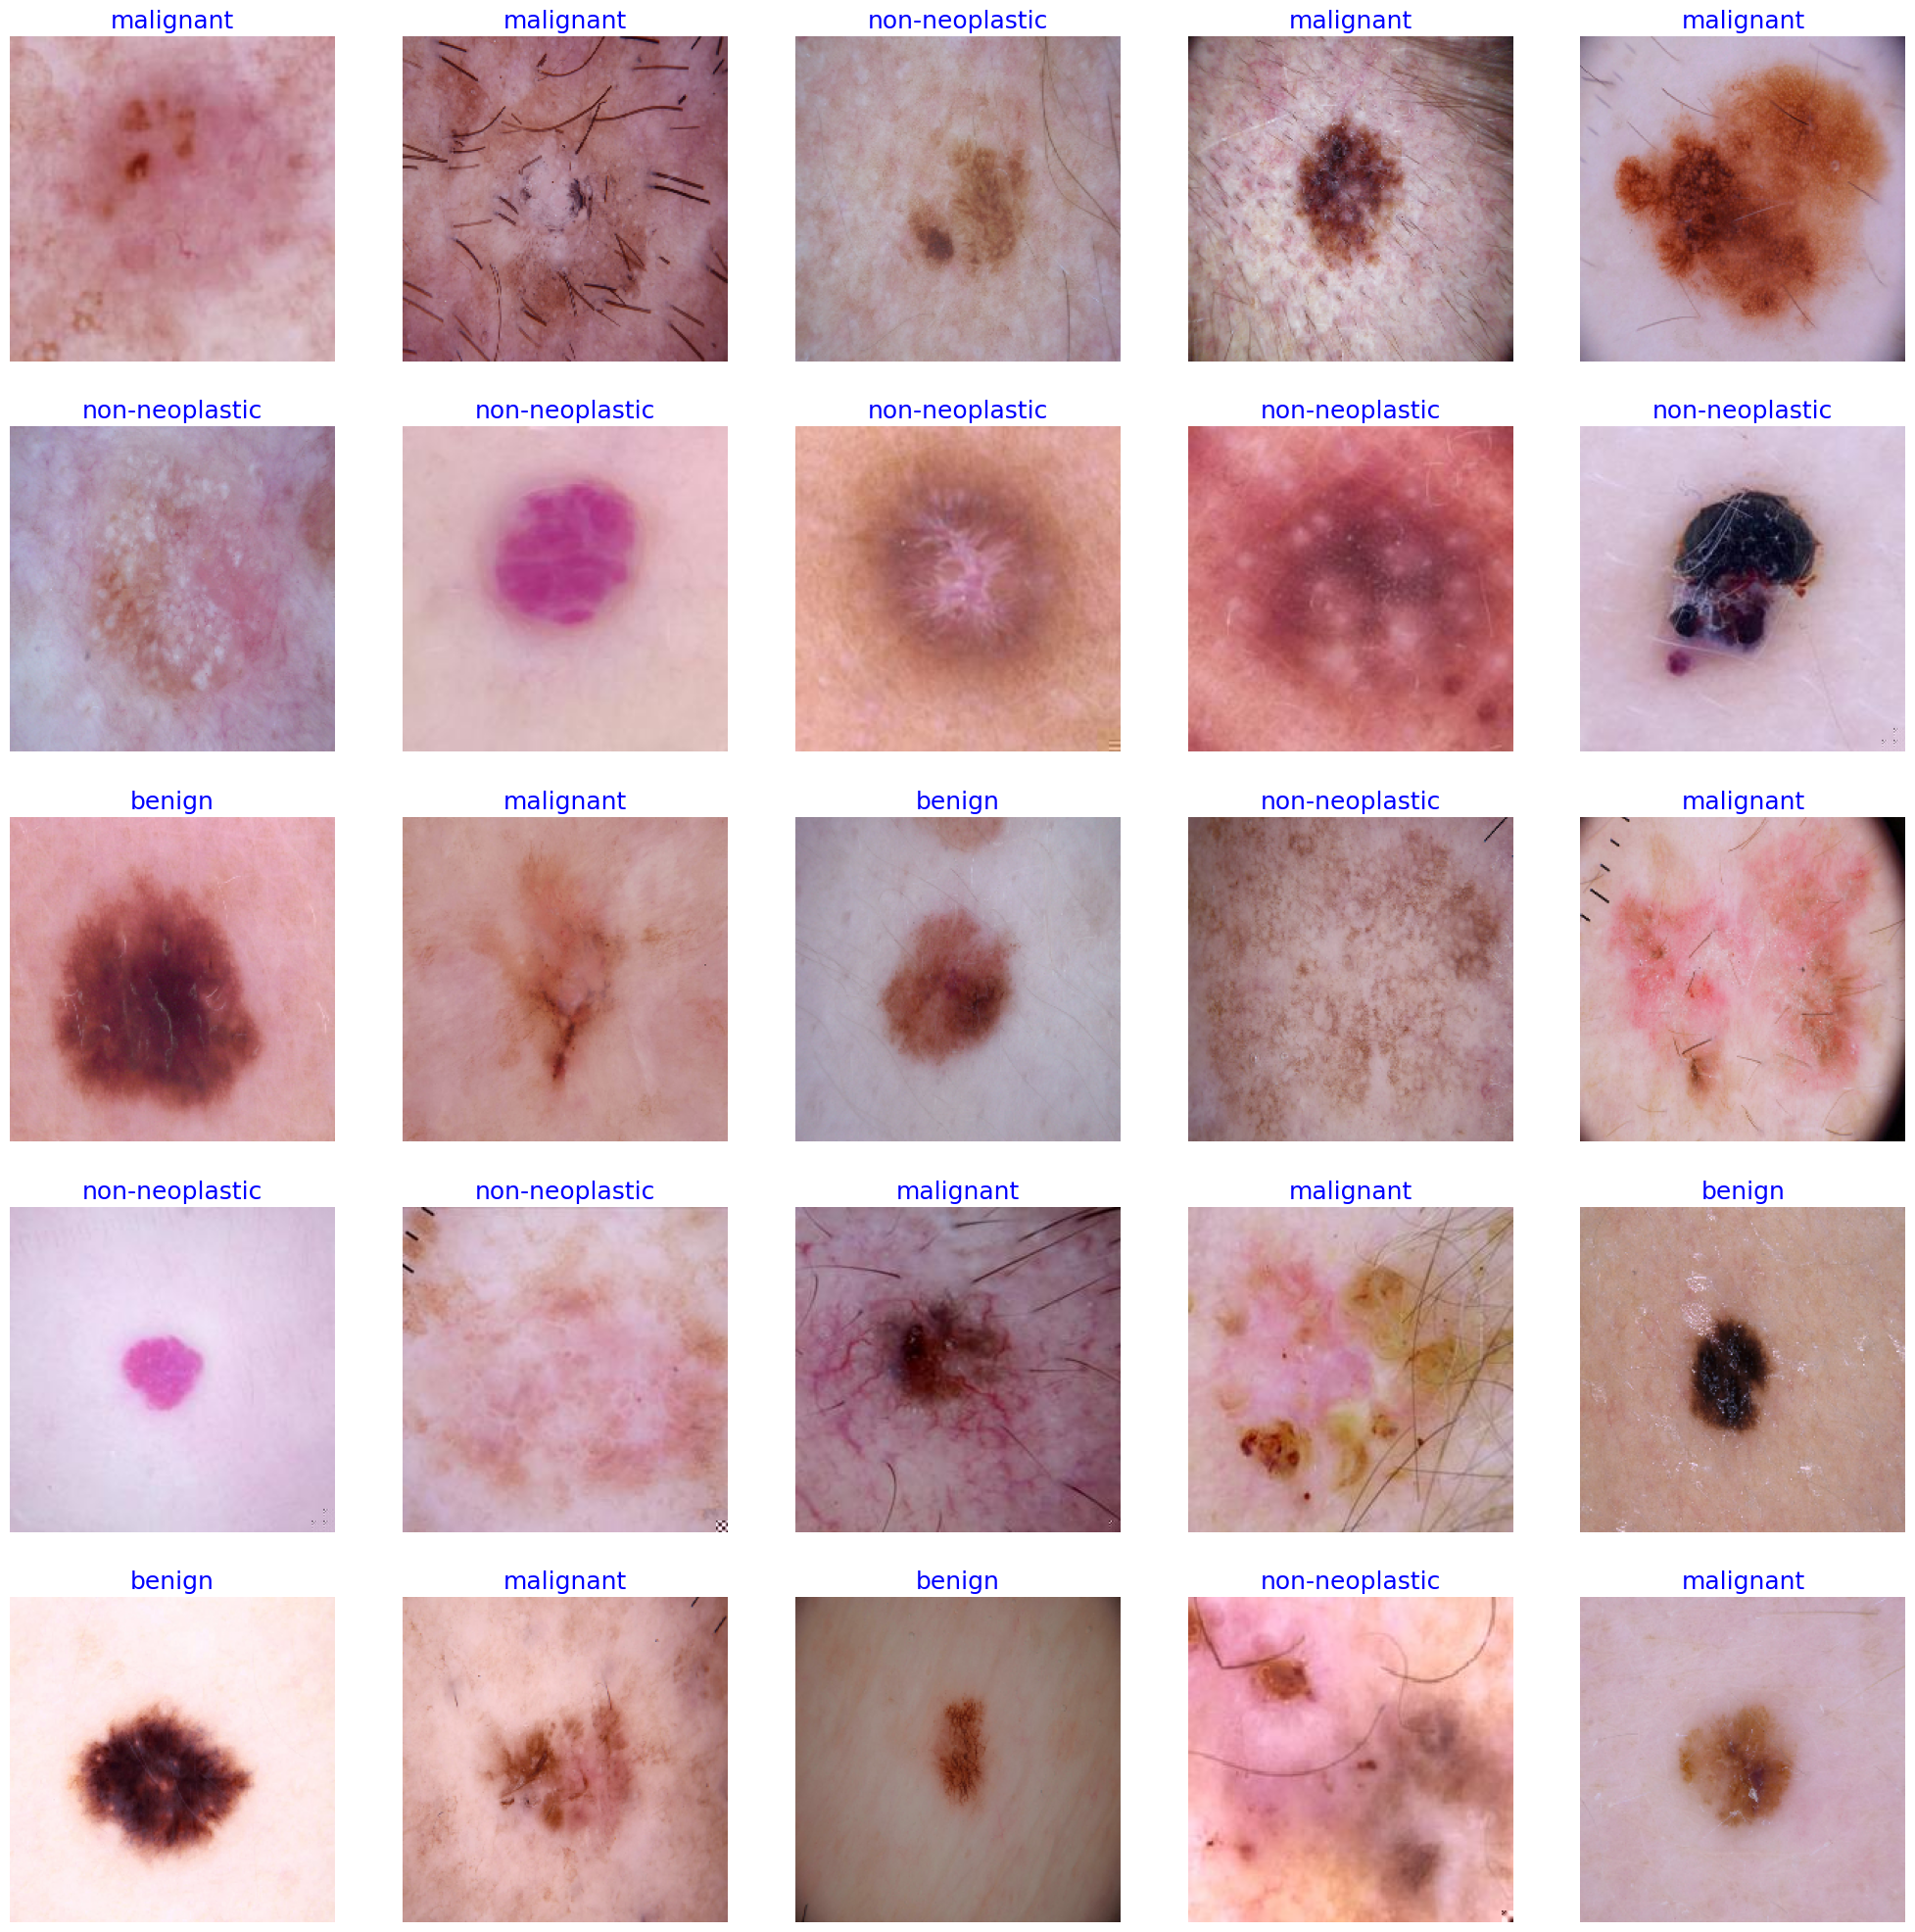

In [22]:
show_image_samples(train_data_generator)

## ResNet50


In [23]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [25]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop

    # Calculate the learning rate for the current epoch
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
"""# define learning rate scheduler

from tensorflow.keras.callbacks import LearningRateScheduler
# Define differential learning rates for different layers
lr_rates = {
    'dense_1': 1e-4,  # Adjust the learning rate for the dense layer
    'dense_2': 1e-6,  # Adjust the learning rate for the output layer
}

# Implement learning rate scheduler with cosine annealing;
def cosine_annealing(epoch):
    max_lr = lr_rates['dense_1']
    min_lr = lr_rates['dense_2']
    total_epochs = 10  # Adjust the total number of epochs
    cos_val = (1 + math.cos(math.pi * epoch / total_epochs)) / 2
    return min_lr + (max_lr - min_lr) * cos_val

lr_scheduler = LearningRateScheduler(cosine_annealing) # Applying a Learning rate scheduler"""


In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import math

# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x) 
#x = Conv2D(64, (3, 3), activation='relu')(x) --> this made things worse... could still be interesting to add a conv block here though...
#x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
#x = Dense(1024, activation='relu')(x) # fully connected layer with 1024 neurons and ReLU activation, relu is used to introduce non-linearity
x= Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x, name='Resnet50_tertiary_repaired')

# Compile the model with a custom optimizer (SGD with momentum)
custom_optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_score])

# Print model summary
model.summary()

Model: "Resnet50_tertiary_repaired"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                     

## Model Training

In [28]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.335111111111111, 1: 0.7776791000592066, 2: 0.7776791000592066}

In [29]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,                # Set the batch size, default is 32, can be increased to speed up training, but memory consumption increases
    callbacks=[lr_scheduler],                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=class_weights,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/40
165/165 [==============================] - 1118s 7s/step - loss: 0.5841 - accuracy: 0.7343 - f1_score: 0.7218 - val_loss: 10.6770 - val_accuracy: 0.1359 - val_f1_score: 0.1378 - lr: 1.0000e-04
Epoch 2/40
165/165 [==============================] - 1133s 7s/step - loss: 0.2823 - accuracy: 0.8793 - f1_score: 0.8787 - val_loss: 6.2709 - val_accuracy: 0.1359 - val_f1_score: 0.1353 - lr: 1.0000e-04
Epoch 3/40
165/165 [==============================] - 1126s 7s/step - loss: 0.1611 - accuracy: 0.9315 - f1_score: 0.9330 - val_loss: 12.9679 - val_accuracy: 0.1359 - val_f1_score: 0.1353 - lr: 1.0000e-04
Epoch 4/40
165/165 [==============================] - 1130s 7s/step - loss: 0.1338 - accuracy: 0.9494 - f1_score: 0.9491 - val_loss: 9.2678 - val_accuracy: 0.1409 - val_f1_score: 0.1377 - lr: 1.0000e-04
Epoch 5/40
165/165 [==============================] - 1125s 7s/step - loss: 0.0482 - accuracy: 0.9812 - f1_score: 0.9796 - val_loss: 6.8009 - val_accuracy: 0.1898 - val_f1_score: 0.1905 

## Plotting accuracy and loss of train and validation set

(0.0, 1.0)

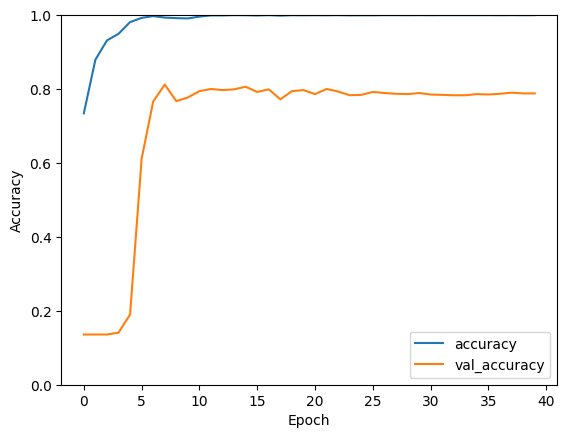

In [30]:
import matplotlib.pyplot as plt
mh.model_plot_accuracy(history)
plt.ylim(0,1)

## Evaluating the model on the test set

 > Evaluating model Resnet50_tertiary_repaired:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 35s 1s/step
 > Model predictions obtained.
 > Macro AUC: 0.935265616662113
 > Micro AUC: 0.9319781096489654


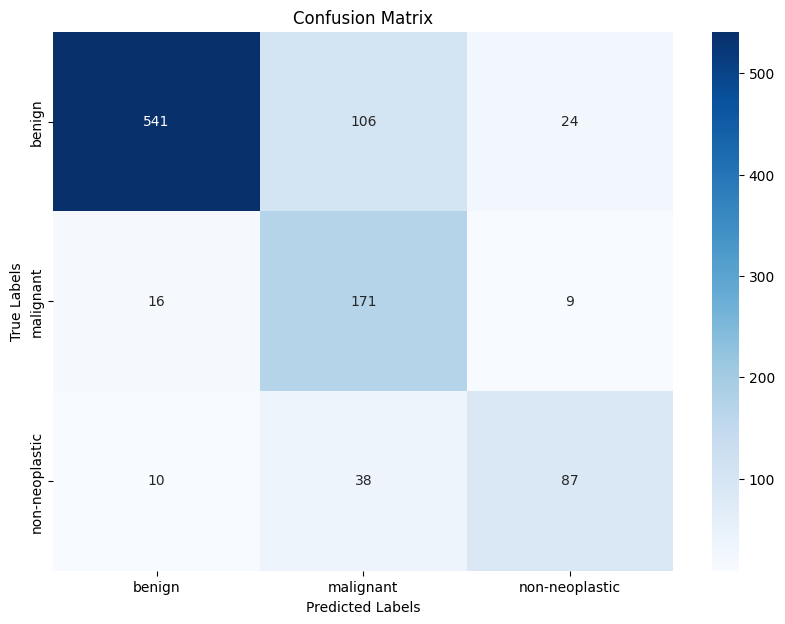



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       671
           1       0.54      0.87      0.67       196
           2       0.72      0.64      0.68       135

    accuracy                           0.80      1002
   macro avg       0.74      0.77      0.74      1002
weighted avg       0.84      0.80      0.81      1002

 > Evaluating model on test set...
32/32 [==============================] - 36s 1s/step - loss: 1.1115 - accuracy: 0.7974 - f1_score: 0.7890
loss: 1.1114847660064697
accuracy: 0.7974051833152771
f1_score: 0.7890221476554871
 > Done.


([{'loss': 1.1114847660064697},
  {'accuracy': 0.7974051833152771},
  {'f1_score': 0.7890221476554871}],
 array([[541, 106,  24],
        [ 16, 171,   9],
        [ 10,  38,  87]]),
 (0.9319781096489654, 0.935265616662113))

In [31]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)